<a href="https://colab.research.google.com/github/alfinmaulani/skripsi/blob/master/combined(glove).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade scikit-learn
import numpy as np
import pandas as pd
import io
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import gensim

     |████████████████████████████████| 23.2 MB 133 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [175]:
url0='https://raw.githubusercontent.com/alfinmaulani/skripsi/master/dataISEAR.csv'
df = pd.read_csv(url0)

In [178]:
df.emosi.value_counts()

joy        1092
sadness    1082
anger      1079
fear       1076
disgust    1066
Name: emosi, dtype: int64

In [176]:
df=df.drop(df[df['emosi'] == 'shame'].sample(frac=1).index)
df=df.drop(df[df['emosi'] == 'guilt'].sample(frac=1).index)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [177]:
df2 = pd.read_csv('/content/drive/MyDrive/twitter_prosessed.csv')

preputama : lower case

In [179]:
df['dokumen']=df['dokumen'].str.lower()
# print(df.iloc[4,1])

In [180]:
df2['tweet']=df2['tweet'].str.lower()

preputama : Pembersihan noise (over enter and space)

In [181]:
df=df.replace(' \n', ' ', regex=True)
df=df.replace('   ', ' ', regex=True)
df=df.replace('  ', ' ', regex=True)

In [182]:
df2=df2.replace(' \n', ' ', regex=True)
df2=df2.replace('   ', ' ', regex=True)
df2=df2.replace('  ', ' ', regex=True)

preptambah : expand contractions

In [39]:
!pip install contractions
import contractions

     |████████████████████████████████| 284 kB 5.7 MB/s 
     |████████████████████████████████| 321 kB 36.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85451 sha256=e2042a36f0c71e9c6887a89f911903398026e68729ae058230669f8cf5f1894f
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [122]:
expanded_words = []   
for word in df.dokumen:
  expanded_words.append(contractions.fix(word))
df.dokumen=expanded_words

In [123]:
expanded_words = []
for word in df2.tweet:
  expanded_words.append(contractions.fix(word))
df2.tweet=expanded_words

preputama : cleansing punctuation

In [124]:
df['dokumen'] = df['dokumen'].str.replace(r'[^\w\s]+', '')

In [125]:
df2['tweet'] = df2['tweet'].str.replace(r'[^\w\s]+', '')

preputama : cleansing number

In [12]:
!pip install tweet-preprocessor
import preprocessor as p

In [126]:
p.set_options(p.OPT.NUMBER)

In [127]:
sementara=[]
for word in df.dokumen:
  sementara.append(p.clean(word))
df.dokumen=sementara

In [128]:
sementara=[]
for word in df2.tweet:
  sementara.append(p.clean(word))
df2.tweet=sementara

preptambah : remove stopword

In [47]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [129]:
pat = r'\b(?:{})\b'.format('|'.join(stop))

In [130]:
df['dokumen'] = df['dokumen'].str.replace(pat, '')
df['dokumen'] = df['dokumen'].str.replace(r'\s+', ' ')

In [131]:
df2['tweet'] = df2['tweet'].str.replace(pat, '')
df2['tweet'] = df2['tweet'].str.replace(r'\s+', ' ')

tokenizing

In [183]:
sentences = [word_tokenize(x) for x in df.dokumen] 
# df = pd.DataFrame(df.apply(list,axis=1), columns=['dokumen'])
df.dokumen=sentences

In [184]:
sentences = [word_tokenize(x) for x in df2.tweet]
df2.tweet=sentences

preptambah : Lemmatization

In [53]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [134]:
df['dokumen'].apply(lambda x: [stemmer.stem(y) for y in x])

0       [day, feel, close, partner, friend, feel, peac...
1       [everi, time, imagin, someon, love, could, con...
2               [obvious, unjust, treat, possibl, elucid]
3       [think, short, time, live, relat, period, life...
4       [gather, found, involuntarili, sit, next, two,...
                              ...                        
7506    [roommat, like, listen, meaningless, song, mel...
7509                    [receiv, letter, distant, friend]
7510    [parent, eldest, home, midnight, male, strange...
7513    [home, heard, loud, sound, spit, outsid, door,...
7515    [shout, younger, brother, alway, afraid, call,...
Name: dokumen, Length: 5395, dtype: object

In [135]:
df2['tweet'].apply(lambda x: [stemmer.stem(y) for y in x])

0          [upset, can, not, updat, facebook, text, might...
1          [dive, mani, time, ball, manag, save, rest, go...
2                     [whole, bodi, feel, itchi, like, fire]
3                             [behav, i, mad, can, not, see]
4                                              [whole, crew]
                                 ...                        
1596959                     [woke, school, best, feel, ever]
1596960     [thewdbcom, cool, hear, old, walt, interview, â]
1596961                   [readi, mojo, makeov, ask, detail]
1596962    [happi, th, birthday, boo, alll, time, tupac, ...
1596963                                              [happi]
Name: tweet, Length: 1596964, dtype: object

save df

In [ ]:
# df.to_csv(r'dataisear(preptambah).csv', index = False)

gabung corpus

In [ ]:
# sent=df.dokumen

In [185]:
sent=df2.tweet.append(df.dokumen,ignore_index=True)

glove

In [19]:
!pip install glove-python-binary

     |████████████████████████████████| 948 kB 5.4 MB/s 


In [20]:
from glove import Glove
from glove import Corpus

In [186]:
korpus = Corpus()
korpus.fit(sent, window=10, ignore_missing=False)

In [187]:
glove = Glove(no_components=100, learning_rate=0.05, alpha=0.75, max_count=100, max_loss=10.0, random_state=None)
glove.fit(korpus.matrix)
glove.add_dictionary(korpus.dictionary)

cek moedel

In [23]:
glove.word_vectors.shape

(431071, 100)

In [174]:
glove.word_vectors[glove.dictionary['moment']]

array([-0.1520755 ,  0.11001179,  0.09849952,  0.11239919,  0.19851514,
        0.20862444,  0.1932002 , -0.02995237,  0.06225874, -0.06340693,
        0.17249209,  0.10428308,  0.13167693, -0.1409929 , -0.08721758,
       -0.17292561, -0.14640743, -0.12575977, -0.15178732,  0.1147141 ,
       -0.02979676,  0.12960953,  0.11416369, -0.13766298, -0.08685944,
        0.12587161,  0.16967787, -0.08993313,  0.22015248,  0.08793198,
        0.09437949, -0.16666762,  0.15203701, -0.09827079,  0.06624353,
        0.05642047,  0.18682406,  0.11917908, -0.11538529,  0.02378679,
        0.14371305, -0.16219357, -0.18656432,  0.08556306,  0.07295119,
        0.17236783, -0.2082566 , -0.12523906, -0.10716872, -0.13240827,
        0.20221052, -0.0451977 , -0.0284566 ,  0.15083394, -0.12145719,
       -0.08591052, -0.21156101,  0.21358733, -0.10536546, -0.09632493,
        0.16145697,  0.15278694,  0.06723223, -0.08208913, -0.14172974,
        0.146254  ,  0.15765845, -0.19882692, -0.09842107,  0.20

ekstraksi fitur

In [188]:
import array
ekstrak=[]
temp=array.array('i',(0,)*100)
for senten in df.dokumen:
  for word in senten:
    temp=np.add(temp,glove.word_vectors[glove.dictionary[word]])
  temp=temp/len(senten)
  ekstrak.append(temp)
has_vec=ekstrak

In [189]:
X=has_vec
y=df.emosi
print(np.shape(X))
print(np.shape(y))
# print(X)
# print(y)

(5395, 100)
(5395,)


klasifikasi svm

In [27]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [ ]:
# langsung cari score

# clf = svm.SVC(kernel='poly', decision_function_shape='ovr')
# scores = cross_val_score(clf, X, y, cv=10)
# # scores.mean()

0.2851325891718843

conf matrix dan akurasi

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

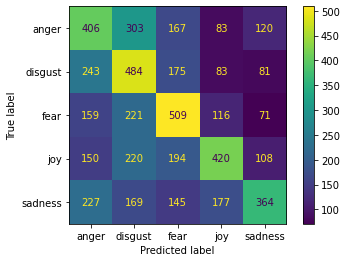

0.4046339202965709
(0.416773366118459, 0.40487717180011595, 0.4051577850977674, None)


In [190]:
clf = svm.SVC(kernel='poly', decision_function_shape='ovr')
y_pred = cross_val_predict(clf, X, y, cv=10)
ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.show()
print(accuracy_score(y, y_pred))
print(precision_recall_fscore_support(y, y_pred, average='macro'))

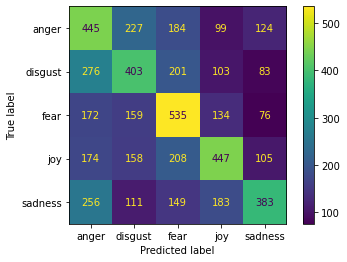

0.410194624652456
(0.4191410360106225, 0.4101988728260716, 0.41050438437934356, None)


In [191]:
clf = svm.SVC(kernel='rbf', decision_function_shape='ovr')
y_pred = cross_val_predict(clf, X, y, cv=10)
ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.show()
print(accuracy_score(y, y_pred))
print(precision_recall_fscore_support(y, y_pred, average='macro'))

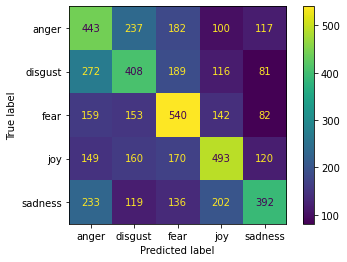

0.42187210379981466
(0.4276773541364259, 0.42178410791287496, 0.42184933559291204, None)


In [192]:
clf = svm.SVC(kernel='linear', decision_function_shape='ovr')
y_pred = cross_val_predict(clf, X, y, cv=10)
ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.show()
print(accuracy_score(y, y_pred))
print(precision_recall_fscore_support(y, y_pred, average='macro'))